### 观察模型 `llava-v1.6-mistral-7b-hf` 在多轮攻击数据集 `tom-gibbs/multi-turn_jailbreak_attack_datasets` 上的隐藏层中的张量特征随着攻击轮次的变化

#### 读取多轮攻击过程中隐藏层张量及对应的labels, mt_nums

In [1]:
import torch

layer_0 = torch.load("./embeddings/pure_mt/layer_0.pt").to(torch.float32).cpu()
layer_8 = torch.load("./embeddings/pure_mt/layer_8.pt").to(torch.float32).cpu()
layer_16 = torch.load("./embeddings/pure_mt/layer_16.pt").to(torch.float32).cpu()
layer_24 = torch.load("./embeddings/pure_mt/layer_24.pt").to(torch.float32).cpu()
layer_32 = torch.load("./embeddings/pure_mt/layer_32.pt").to(torch.float32).cpu()

mt_nums = torch.load("./embeddings/pure_mt/mt_nums.pt").cpu() # 原始多轮对话轮数
labels = torch.load("./embeddings/pure_mt/labels.pt").cpu()   # 流式攻击标签，1为攻击成功， 0为攻击失败

#### 提取攻击过程中各多轮对话的隐藏层张量特征的初始状态(init)、中间状态(intermediate)、终轮状态(final)
| 初始状态(init)                           | 中间状态(intermediate)                                       | 终轮状态(final)                                              |
| ---------------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| 多轮攻击中第一个对话轮次的隐藏层向量特征 | $\frac{turn_{init} + turn_{final}}{2}$对话轮次的隐藏层向量特征 | 多轮攻击中攻击成功所处对话轮次的隐藏层向量特征/多轮攻击中最后一个对话轮次的隐藏层向量特征 |

In [2]:
init_indices = []
selected_indices = []
intermediate_indices = []
mt_attack_labels = []   # 对应的多轮攻击标签，1为攻击成功， 0为攻击失败
attack_success_turns = []   # 对应的多轮攻击若成功，记录攻击成功所在的轮数；对应的多轮攻击若失败，以-1表示

start = 0
for interval_length in mt_nums.tolist():
    init_indices.append(start)  # 该多轮攻击的初始状态索引
    end = start + interval_length
    sub_labels = labels[start:end]
    # 查找第一个label==1的位置
    positive_indices = (sub_labels == 1).nonzero(as_tuple=True)[0]
    if len(positive_indices) > 0:
        # 如果存在1，取第一个1的索引（转换回labels的全局索引）
        selected_idx = start + positive_indices[0].item()
        mt_attack_labels.append(1)
        attack_success_turns.append(positive_indices[0].item() + 1) # 轮数从1开始计数
    else:
        # 否则取该段最后一个索引（多轮攻击失败sample）
        selected_idx = end - 1
        mt_attack_labels.append(0)
        attack_success_turns.append(-1)

    selected_indices.append(selected_idx)
    start = end

# 计算中间状态索引
intermediate_indices = [
    (init_idx + sel_idx) // 2
    for init_idx, sel_idx in zip(init_indices, selected_indices)
]

# 转为tensor
init_indices = torch.tensor(init_indices, dtype=torch.long)
intermediate_indices = torch.tensor(intermediate_indices, dtype=torch.long)
selected_indices = torch.tensor(selected_indices, dtype=torch.long)
mt_attack_labels = torch.tensor(mt_attack_labels, dtype=torch.long)
attack_success_turns = torch.tensor(attack_success_turns, dtype=torch.long)

In [3]:
init_indices, selected_indices, intermediate_indices

(tensor([  0,  11,  24,  35,  48,  60,  70,  82,  91, 101, 109, 118, 131, 139,
         150, 159, 170, 178, 187, 196, 209, 221, 233, 242, 254, 263, 275, 286,
         294, 303, 311, 320, 332, 345, 358, 369, 379, 387, 399, 408, 419, 432,
         441, 450, 458, 469, 481, 493, 506, 518, 530, 542, 555, 568, 575, 588,
         599, 606, 619, 628, 639, 651, 664, 677]),
 tensor([ 10,  23,  34,  47,  59,  69,  81,  90, 100, 108, 117, 130, 138, 149,
         158, 169, 177, 186, 195, 208, 220, 232, 241, 253, 262, 274, 285, 293,
         302, 310, 319, 331, 344, 357, 368, 378, 386, 398, 407, 418, 431, 440,
         449, 457, 468, 480, 492, 505, 517, 529, 541, 554, 567, 574, 587, 598,
         605, 618, 627, 638, 650, 659, 676, 689]),
 tensor([  5,  17,  29,  41,  53,  64,  75,  86,  95, 104, 113, 124, 134, 144,
         154, 164, 173, 182, 191, 202, 214, 226, 237, 247, 258, 268, 280, 289,
         298, 306, 315, 325, 338, 351, 363, 373, 382, 392, 403, 413, 425, 436,
         445, 453, 463, 474, 

In [5]:
layer_0_features_init = layer_0[init_indices]
layer_0_features_intermediate = layer_0[intermediate_indices]
layer_0_features_final = layer_0[selected_indices]

layer_8_features_init = layer_8[init_indices]
layer_8_features_intermediate = layer_8[intermediate_indices]
layer_8_features_final = layer_8[selected_indices]

layer_16_features_init = layer_16[init_indices]
layer_16_features_intermediate = layer_16[intermediate_indices]
layer_16_features_final = layer_16[selected_indices]

layer_24_features_init = layer_24[init_indices]
layer_24_features_intermediate = layer_24[intermediate_indices]
layer_24_features_final = layer_24[selected_indices]

layer_32_features_init = layer_32[init_indices]
layer_32_features_intermediate = layer_32[intermediate_indices]
layer_32_features_final = layer_32[selected_indices]

#### $R^{4096,4097}$双曲空间上与原点$[\sqrt{\frac{1}{c}},0,...,0]$的洛伦兹距离分布，`curv=1.0`

In [18]:
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
import numpy as np
from utils.lorentz import exp_map0, elementwise_dist

# 定义双曲空间的曲率
curv = 1.0

# 逐层映射到双曲空间（只传空间维度）
layer_0_features_init_hyp = exp_map0(layer_0_features_init, curv)
layer_0_features_intermediate_hyp = exp_map0(layer_0_features_intermediate, curv)
layer_0_features_final_hyp = exp_map0(layer_0_features_final, curv)

layer_8_features_init_hyp = exp_map0(layer_8_features_init, curv)
layer_8_features_intermediate_hyp = exp_map0(layer_8_features_intermediate, curv)
layer_8_features_final_hyp = exp_map0(layer_8_features_final, curv)

layer_16_features_init_hyp = exp_map0(layer_16_features_init, curv)
layer_16_features_intermediate_hyp = exp_map0(layer_16_features_intermediate, curv)
layer_16_features_final_hyp = exp_map0(layer_16_features_final, curv)

layer_24_features_init_hyp = exp_map0(layer_24_features_init, curv)
layer_24_features_intermediate_hyp = exp_map0(layer_24_features_intermediate, curv)
layer_24_features_final_hyp = exp_map0(layer_24_features_final, curv)

layer_32_features_init_hyp = exp_map0(layer_32_features_init, curv)
layer_32_features_intermediate_hyp = exp_map0(layer_32_features_intermediate, curv)
layer_32_features_final_hyp = exp_map0(layer_32_features_final, curv)

B, D = layer_0_features_init_hyp.shape  # D = 4096
# 构造原点 O（全零空间向量）
O = torch.zeros(D, device=layer_0_features_init_hyp.device, dtype=layer_0_features_init_hyp.dtype)
O = O.unsqueeze(0).expand(B, -1)  # [B, D]

# 分别计算每层到原点的距离
dist_0_init = elementwise_dist(layer_0_features_init_hyp, O, curv=curv)
dist_0_intermediate = elementwise_dist(layer_0_features_intermediate_hyp, O, curv=curv)
dist_0_final = elementwise_dist(layer_0_features_final_hyp, O, curv=curv)

dist_8_init = elementwise_dist(layer_8_features_init_hyp, O, curv=curv)
dist_8_intermediate = elementwise_dist(layer_8_features_intermediate_hyp, O, curv=curv)
dist_8_final = elementwise_dist(layer_8_features_final_hyp, O, curv=curv)

dist_16_init = elementwise_dist(layer_16_features_init_hyp, O, curv=curv)
dist_16_intermediate = elementwise_dist(layer_16_features_intermediate_hyp, O, curv=curv)
dist_16_final = elementwise_dist(layer_16_features_final_hyp, O, curv=curv)

dist_24_init = elementwise_dist(layer_24_features_init_hyp, O, curv=curv)
dist_24_intermediate = elementwise_dist(layer_24_features_intermediate_hyp, O, curv=curv)
dist_24_final = elementwise_dist(layer_24_features_final_hyp, O, curv=curv)

dist_32_init = elementwise_dist(layer_32_features_init_hyp, O, curv=curv)
dist_32_intermediate = elementwise_dist(layer_32_features_intermediate_hyp, O, curv=curv)
dist_32_final = elementwise_dist(layer_32_features_final_hyp, O, curv=curv)

In [12]:
dist_0_final

tensor([0.0303, 0.0337, 0.0333, 0.0341, 0.0339, 0.0332, 0.0336, 0.0334, 0.0332,
        0.0336, 0.0310, 0.0338, 0.0328, 0.0333, 0.0329, 0.0332, 0.0335, 0.0329,
        0.0329, 0.0337, 0.0339, 0.0339, 0.0329, 0.0318, 0.0322, 0.0339, 0.0340,
        0.0330, 0.0329, 0.0330, 0.0334, 0.0312, 0.0342, 0.0336, 0.0340, 0.0332,
        0.0328, 0.0333, 0.0310, 0.0337, 0.0336, 0.0334, 0.0334, 0.0342, 0.0340,
        0.0341, 0.0336, 0.0341, 0.0335, 0.0339, 0.0336, 0.0336, 0.0341, 0.0325,
        0.0338, 0.0337, 0.0328, 0.0341, 0.0329, 0.0340, 0.0345, 0.0324, 0.0341,
        0.0342])

#### 绘制安全与非安全的样本在模型不同隐藏层的不同状态时特征张量在双曲空间上距离双曲原点的距离分布

/tmp/ipykernel_1237123/3934278586.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_kde.legend(fontsize=7)


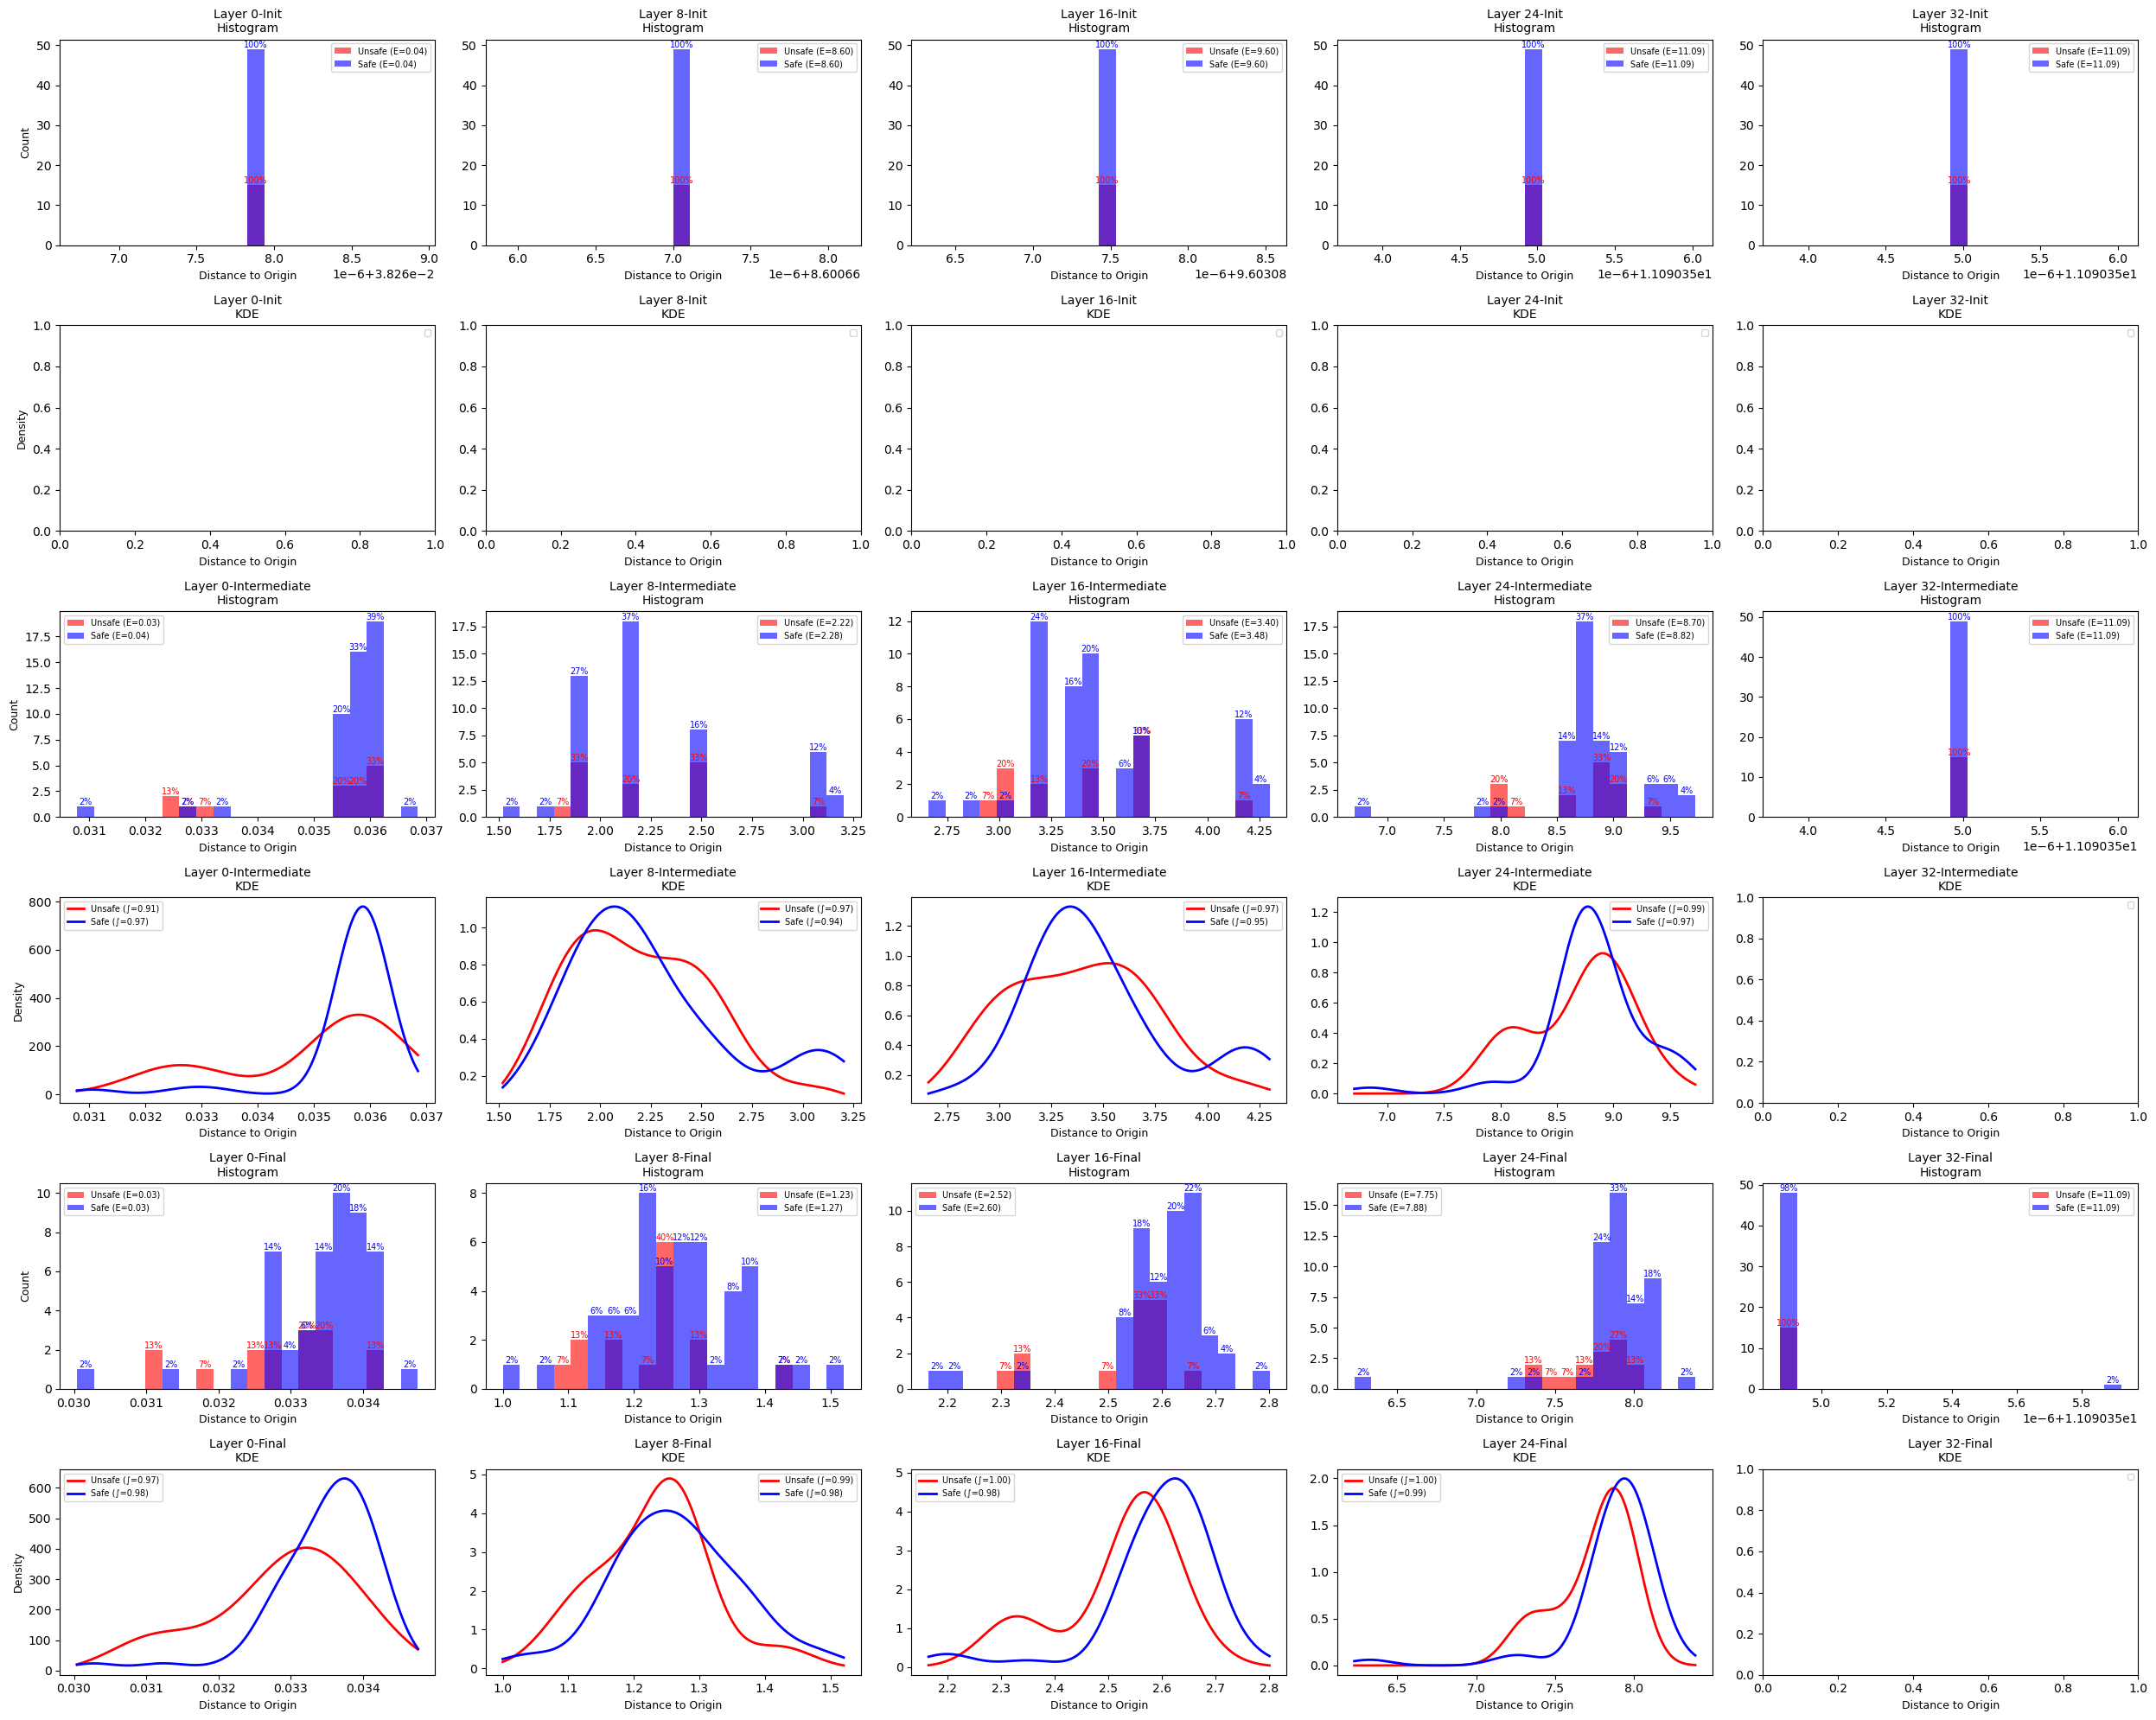

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from numpy import trapz

# 5 层 × 3 状态
layers_states = {
    "Layer 0": {
        "Init": dist_0_init,
        "Intermediate": dist_0_intermediate,
        "Final": dist_0_final
    },
    "Layer 8": {
        "Init": dist_8_init,
        "Intermediate": dist_8_intermediate,
        "Final": dist_8_final
    },
    "Layer 16": {
        "Init": dist_16_init,
        "Intermediate": dist_16_intermediate,
        "Final": dist_16_final
    },
    "Layer 24": {
        "Init": dist_24_init,
        "Intermediate": dist_24_intermediate,
        "Final": dist_24_final
    },
    "Layer 32": {
        "Init": dist_32_init,
        "Intermediate": dist_32_intermediate,
        "Final": dist_32_final
    },
}

num_layers = len(layers_states)         # 5 列
num_states = 3                          # 3 状态，每状态 2 行

# 总行数 = 状态数 × 2(直方图+KDE) = 6 行
fig, axes = plt.subplots(num_states * 2, num_layers,
                         figsize=(25, 20),
                         sharey=False)

# 转换成 2D 数组方便索引
axes = np.array(axes).reshape(num_states * 2, num_layers)

attack_mask = mt_attack_labels.to(torch.bool).cpu().numpy()  # True=Unsafe, False=Safe

for col, (layer_name, state_dict) in enumerate(layers_states.items()):
    for state_idx, (state_name, dist) in enumerate(state_dict.items()):
        # 转 numpy
        dist = dist.to(torch.float).cpu().numpy()
        dist_unsafe = dist[attack_mask]
        dist_safe   = dist[~attack_mask]

        mean_unsafe = dist_unsafe.mean() if len(dist_unsafe) > 0 else float("nan")
        mean_safe   = dist_safe.mean() if len(dist_safe) > 0 else float("nan")

        # 范围
        d_min = min(dist_safe.min(), dist_unsafe.min())
        d_max = max(dist_safe.max(), dist_unsafe.max())
        if d_min == d_max:
            d_min -= 1e-6
            d_max += 1e-6
        margin = 0.05 * (d_max - d_min)
        bin_edges = np.linspace(d_min - margin, d_max + margin, 21)

        # -------------------- 直方图 --------------------
        ax_hist = axes[state_idx * 2, col]
        counts_unsafe, _, patches_unsafe = ax_hist.hist(
            dist_unsafe, bins=bin_edges, color="red", alpha=0.6,
            label=f"Unsafe (E={mean_unsafe:.2f})"
        )
        counts_safe, _, patches_safe = ax_hist.hist(
            dist_safe, bins=bin_edges, color="blue", alpha=0.6,
            label=f"Safe (E={mean_safe:.2f})"
        )

        # 百分比标注
        perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
        perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
        for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
            if count > 0:
                ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                             f"{perc:.0f}%", ha="center", va="bottom",
                             fontsize=7, color="red")
        for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
            if count > 0:
                ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                             f"{perc:.0f}%", ha="center", va="bottom",
                             fontsize=7, color="blue")

        ax_hist.set_title(f"{layer_name}-{state_name}\nHistogram", fontsize=10)
        if col == 0:
            ax_hist.set_ylabel("Count", fontsize=9)
        ax_hist.set_xlabel("Distance to Origin", fontsize=9)
        ax_hist.legend(fontsize=7)

        # -------------------- KDE 曲线 --------------------
        ax_kde = axes[state_idx * 2 + 1, col]
        x_vals = np.linspace(d_min - margin, d_max + margin, 400)

        # Unsafe KDE
        if len(dist_unsafe) > 1 and np.var(dist_unsafe) > 1e-8:
            kde_unsafe = gaussian_kde(dist_unsafe)
            y_unsafe = kde_unsafe(x_vals)
            integral_unsafe = trapz(y_unsafe, x_vals)  # 计算积分
            ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                        label=f"Unsafe (∫={integral_unsafe:.2f})")

        # Safe KDE
        if len(dist_safe) > 1 and np.var(dist_safe) > 1e-8:
            kde_safe = gaussian_kde(dist_safe)
            y_safe = kde_safe(x_vals)
            integral_safe = trapz(y_safe, x_vals)  # 计算积分
            ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                        label=f"Safe (∫={integral_safe:.2f})")

        ax_kde.set_title(f"{layer_name}-{state_name}\nKDE", fontsize=10)
        if col == 0:
            ax_kde.set_ylabel("Density", fontsize=9)
        ax_kde.set_xlabel("Distance to Origin", fontsize=9)
        ax_kde.legend(fontsize=7)

plt.tight_layout()
plt.show()

#### $R^{4096}$上的欧几里得距离分布，欧几里得原点为各隐藏层所有张量的均值并进行了L2归一化

/tmp/ipykernel_1237123/2117975600.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_kde.legend(fontsize=7)


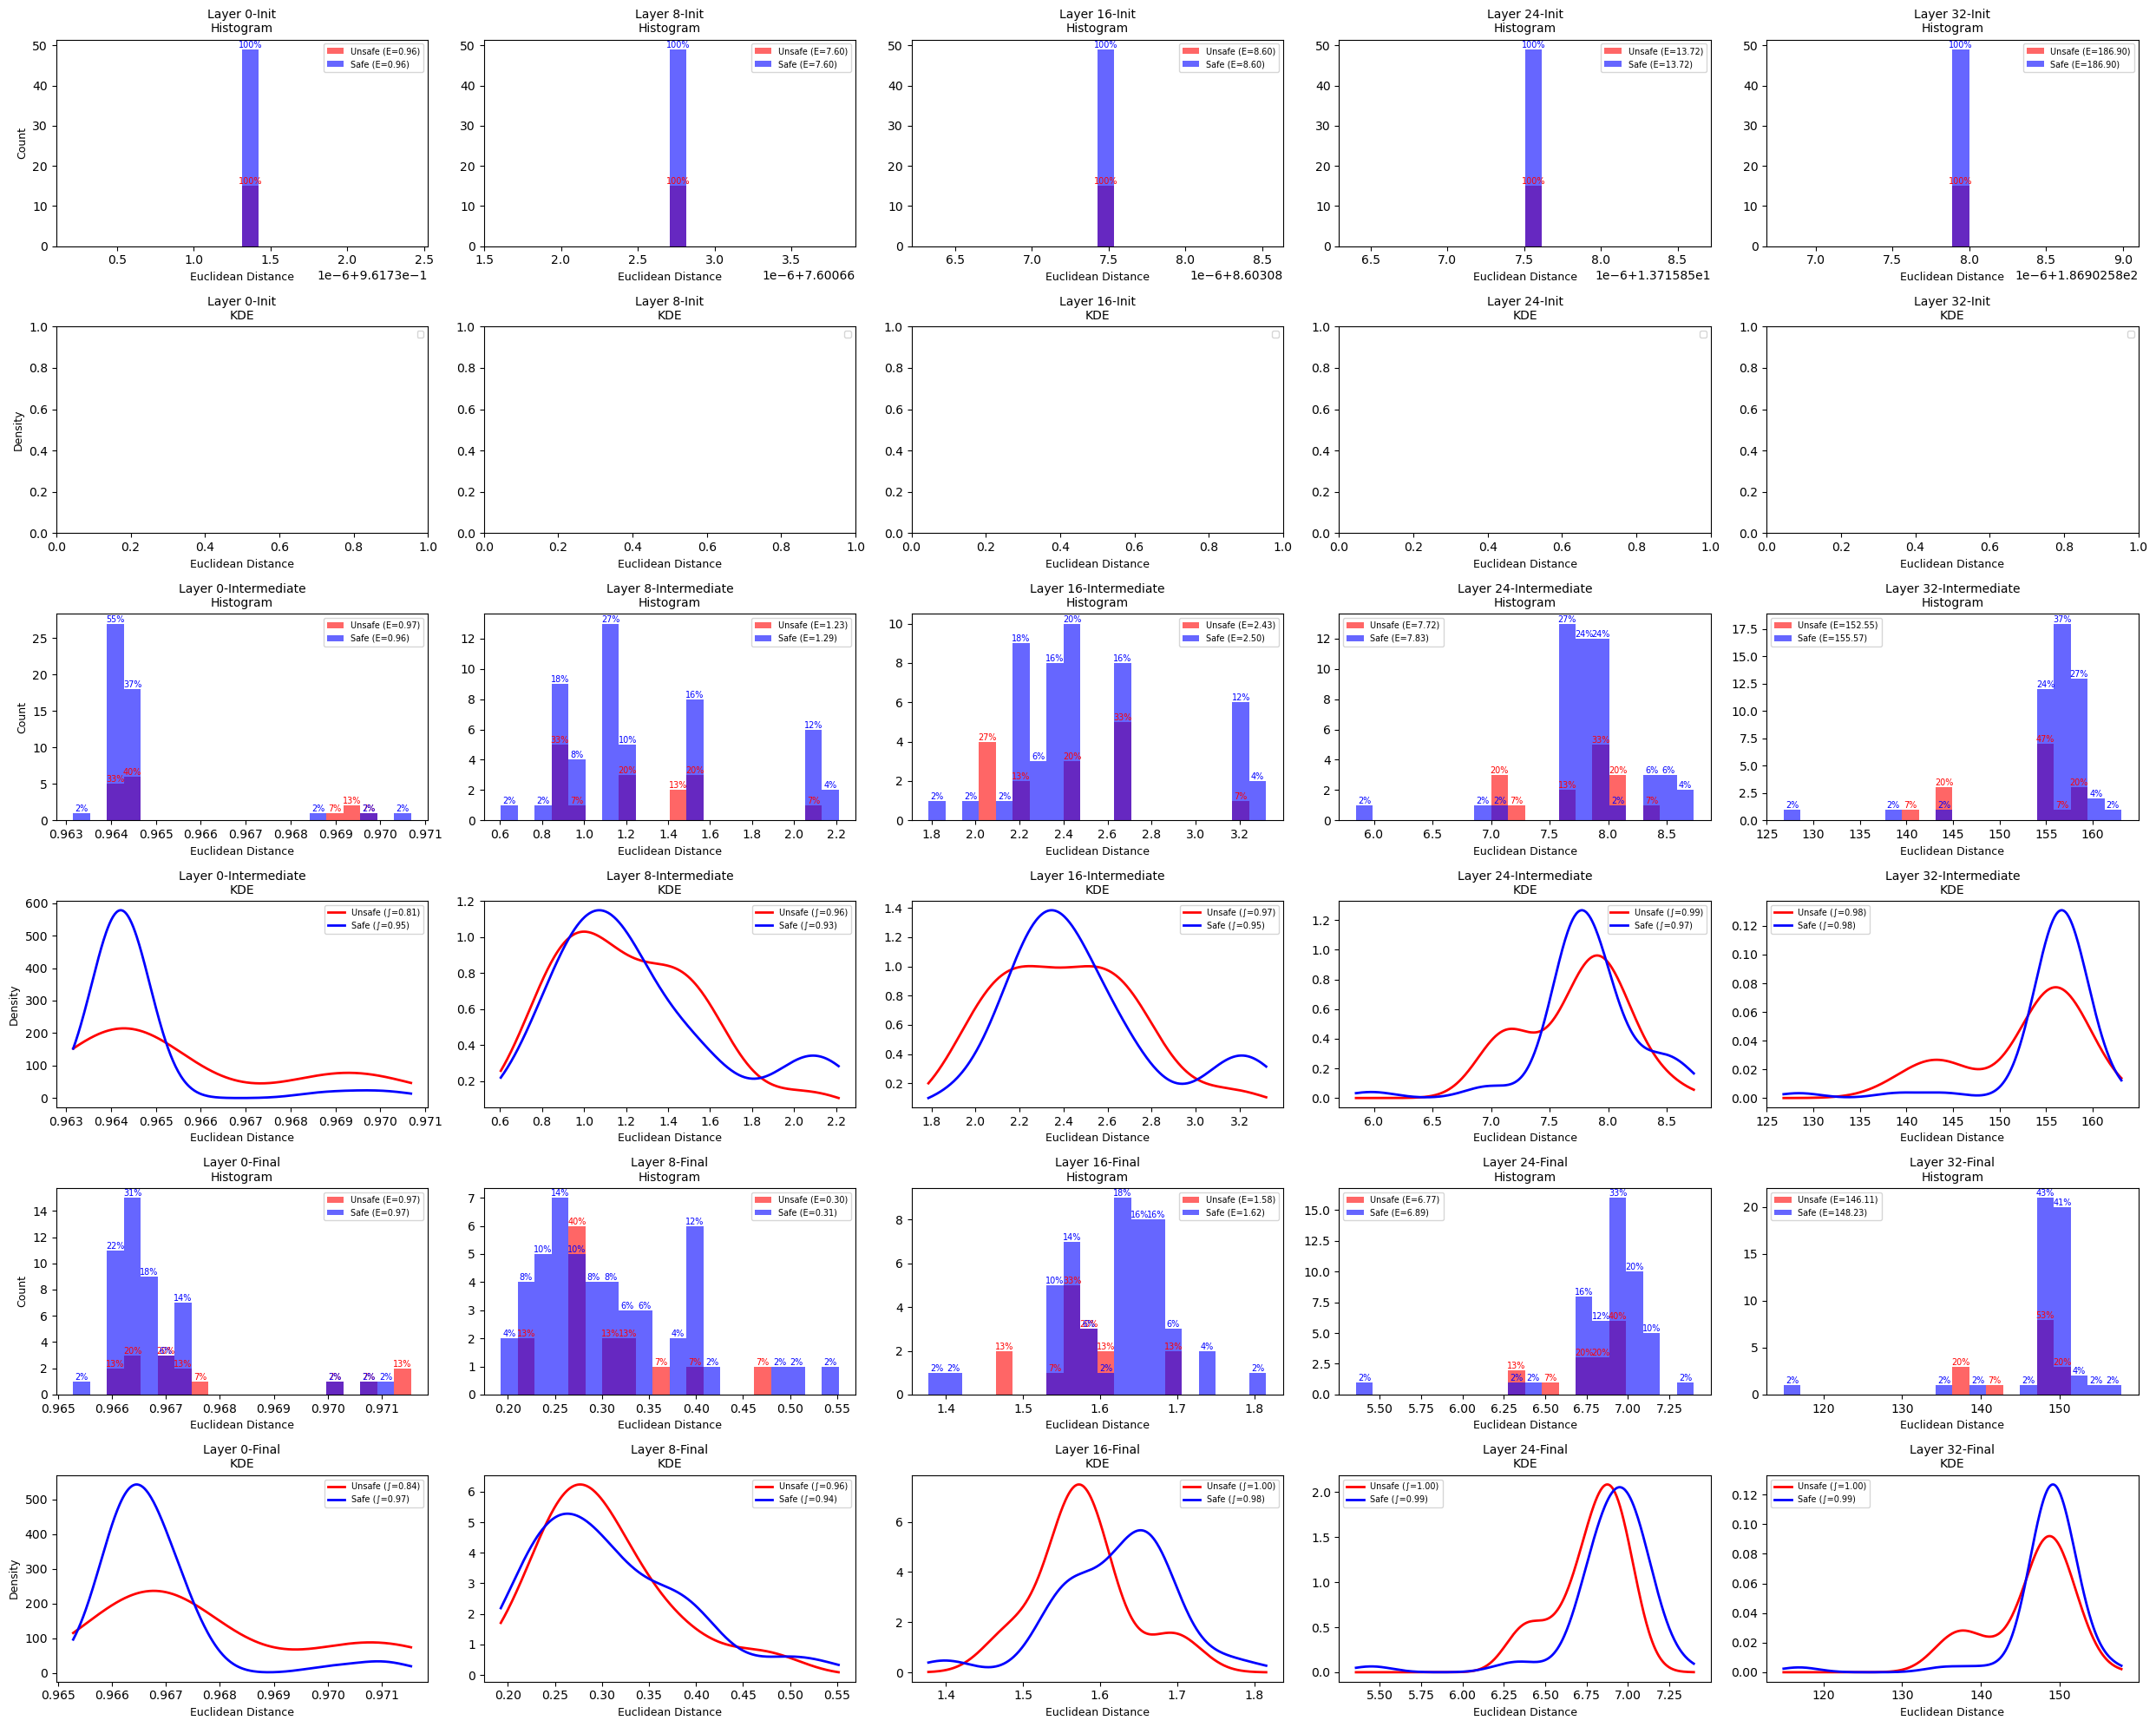

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import trapz
import torch

# ----------------- 组织 5 层 × 3 状态 -----------------
layers_states = {
    "Layer 0": {
        "Init": layer_0_features_init,
        "Intermediate": layer_0_features_intermediate,
        "Final": layer_0_features_final
    },
    "Layer 8": {
        "Init": layer_8_features_init,
        "Intermediate": layer_8_features_intermediate,
        "Final": layer_8_features_final
    },
    "Layer 16": {
        "Init": layer_16_features_init,
        "Intermediate": layer_16_features_intermediate,
        "Final": layer_16_features_final
    },
    "Layer 24": {
        "Init": layer_24_features_init,
        "Intermediate": layer_24_features_intermediate,
        "Final": layer_24_features_final
    },
    "Layer 32": {
        "Init": layer_32_features_init,
        "Intermediate": layer_32_features_intermediate,
        "Final": layer_32_features_final
    },
}

num_layers = len(layers_states)    # 5 列
num_states = 3                     # 3 状态

# 总行数：3状态 × 2（直方图+KDE） = 6 行
fig, axes = plt.subplots(num_states * 2, num_layers,
                         figsize=(25, 20),
                         sharey=False)

axes = np.array(axes).reshape(num_states * 2, num_layers)

attack_mask = mt_attack_labels.to(torch.bool)  # True=Unsafe, False=Safe

# ----------------- 遍历绘制 -----------------
for col, (layer_name, states) in enumerate(layers_states.items()):
    for row_state_idx, (state_name, tensor) in enumerate(states.items()):

        # Step 1: L2 归一化中心点 + 欧几里得距离
        mu = tensor.mean(dim=0, keepdim=True)
        mu_norm = mu / mu.norm(p=2, dim=1, keepdim=True)
        dists = torch.norm(tensor - mu_norm, p=2, dim=1)

        dists_unsafe = dists[attack_mask].cpu().numpy()
        dists_safe   = dists[~attack_mask].cpu().numpy()

        mean_unsafe = dists_unsafe.mean() if len(dists_unsafe) > 0 else float("nan")
        mean_safe   = dists_safe.mean() if len(dists_safe) > 0 else float("nan")

        # 范围
        d_min = min(dists_safe.min(), dists_unsafe.min())
        d_max = max(dists_safe.max(), dists_unsafe.max())
        if d_min == d_max:
            d_min -= 1e-6
            d_max += 1e-6
        margin = 0.05 * (d_max - d_min)
        bin_edges = np.linspace(d_min - margin, d_max + margin, 21)

        # ----------------- 直方图 -----------------
        ax_hist = axes[row_state_idx * 2, col]
        counts_unsafe, _, patches_unsafe = ax_hist.hist(
            dists_unsafe, bins=bin_edges, color="red", alpha=0.6,
            label=f"Unsafe (E={mean_unsafe:.2f})"
        )
        counts_safe, _, patches_safe = ax_hist.hist(
            dists_safe, bins=bin_edges, color="blue", alpha=0.6,
            label=f"Safe (E={mean_safe:.2f})"
        )

        # 百分比标注
        perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
        perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
        for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
            if count > 0:
                ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                             f"{perc:.0f}%", ha="center", va="bottom",
                             fontsize=7, color="red")
        for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
            if count > 0:
                ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                             f"{perc:.0f}%", ha="center", va="bottom",
                             fontsize=7, color="blue")

        ax_hist.set_title(f"{layer_name}-{state_name}\nHistogram", fontsize=10)
        if col == 0:
            ax_hist.set_ylabel("Count", fontsize=9)
        ax_hist.set_xlabel("Euclidean Distance", fontsize=9)
        ax_hist.legend(fontsize=7)

        # ----------------- KDE 曲线 -----------------
        ax_kde = axes[row_state_idx * 2 + 1, col]
        x_vals = np.linspace(d_min - margin, d_max + margin, 400)

        if len(dists_unsafe) > 1 and np.var(dists_unsafe) > 1e-8:
            kde_unsafe = gaussian_kde(dists_unsafe)
            y_unsafe = kde_unsafe(x_vals)
            integral_unsafe = trapz(y_unsafe, x_vals)
            ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                        label=f"Unsafe (∫={integral_unsafe:.2f})")

        if len(dists_safe) > 1 and np.var(dists_safe) > 1e-8:
            kde_safe = gaussian_kde(dists_safe)
            y_safe = kde_safe(x_vals)
            integral_safe = trapz(y_safe, x_vals)
            ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                        label=f"Safe (∫={integral_safe:.2f})")

        ax_kde.set_title(f"{layer_name}-{state_name}\nKDE", fontsize=10)
        if col == 0:
            ax_kde.set_ylabel("Density", fontsize=9)
        ax_kde.set_xlabel("Euclidean Distance", fontsize=9)
        ax_kde.legend(fontsize=7)

plt.tight_layout()
plt.show()